##paper stats generator
ryoung@unlv.edu


In [35]:
# Cell 1

import os
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, cohen_kappa_score, mean_absolute_error

# (Optional) For fuzzy matching
# !pip install rapidfuzz
# from rapidfuzz import process

# Ensure output directory exists
output_dir = '03_data_ai'
os.makedirs(output_dir, exist_ok=True)

# Read the parquet file into a DataFrame
df_stats = pd.read_parquet(f'{output_dir}/part_3_covariates_final.parquet')

print("DataFrame loaded. Shape:", df_stats.shape)
df_stats.head(3)

DataFrame loaded. Shape: (64, 68)


,Index,NCTId,LeadSponsorClass,LeadSponsorName,Condition,OfficialTitle,BriefTitle,Acronym,StudyType,InterventionType,...,relevant_quotes_anthropic_claude_3.5_sonnet,brain_stimulation_used_meta_llama_llama_3_70b_instruct,stimulation_details_primary_type_meta_llama_llama_3_70b_instruct,stimulation_details_is_noninvasive_meta_llama_llama_3_70b_instruct,stimulation_details_primary_target_meta_llama_llama_3_70b_instruct,stimulation_details_secondary_targets_meta_llama_llama_3_70b_instruct,stimulation_details_parameters_intensity_meta_llama_llama_3_70b_instruct,stimulation_details_parameters_duration_meta_llama_llama_3_70b_instruct,confidence_level_meta_llama_llama_3_70b_instruct,relevant_quotes_meta_llama_llama_3_70b_instruct
0,None,NCT06145776,OTHER,Federal University of Paraíba,"Parkinson Disease, Cognition Disorder, EEG Wit...",Effects of Cognitive-motor Dual-Task Training ...,The Role of EEG in Identifying Cognitive Chang...,,INTERVENTIONAL,",",...,"[""It is possible that strategies such as Trans...",Yes,tDCS,True,,[],,,High,"[""Transcranial Direct Current Stimulation can ..."
1,None,NCT04174573,OTHER,Maharishi Markendeswar University (Deemed to b...,Parkinson Disease,Efficacy of Group Therapy With Transcranial Di...,Group Therapy With Transcranial Direct Current...,GTBQ-PD,INTERVENTIONAL,",",...,"[""Transcranial direct current stimulation (tDC...",Yes,tDCS,True,Primary motor cortex M1,[],,20 minutes,High,"[""Anodal tDCS can increase M1 excitability, re..."
2,None,NCT03191916,OTHER,Sanford Health,Parkinson Disease,Transcranial Direct Current Stimulation (tDCS)...,Transcranial Direct Current Stimulation for Co...,tDCS,INTERVENTIONAL,",",...,"[""Transcranial direct current stimulation (tDC...",Yes,tDCS,True,LDLPFC,[],2 milliamps (mA),20 minutes,High,"[""During tDCS, low-voltage, low amplitude curr..."


In [36]:
# Cell 2

def clean_binary_column(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """
    Convert 'Yes'/'No' in col_name to 1/0 and drop rows where mapping fails.
    """
    valid_map = {"Yes": 1, "No": 0}
    df[col_name] = df[col_name].map(valid_map)
    df.dropna(subset=[col_name], inplace=True)
    df[col_name] = df[col_name].astype(int)
    return df

def compute_binary_agreement(df: pd.DataFrame, col_a: str, col_b: str) -> dict:
    """
    Computes confusion matrix, observed agreement, expected agreement,
    and Cohen's Kappa for two binary (0/1) columns.
    """
    a = df[col_a]
    b = df[col_b]

    cm = confusion_matrix(a, b, labels=[0, 1])  # order of labels => [0,1]
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp

    # Observed agreement (p_o)
    p_o = (tp + tn) / total

    # Expected agreement (p_e)
    row1_sum = tp + fn  # total '1' in col A
    row2_sum = fp + tn  # total '0' in col A
    col1_sum = tp + fp  # total '1' in col B
    col2_sum = fn + tn  # total '0' in col B
    p_e = (row1_sum * col1_sum + row2_sum * col2_sum) / (total ** 2)

    # Cohen's Kappa (manual)
    if 1 - p_e == 0:
        kappa_manual = 1.0  # degenerate case
    else:
        kappa_manual = (p_o - p_e) / (1 - p_e)

    # Cross-check with sklearn
    kappa_sklearn = cohen_kappa_score(a, b)

    return {
        "ConfusionMatrix (tn, fp, fn, tp)": (tn, fp, fn, tp),
        "ObservedAgreement": p_o,
        "ExpectedAgreement": p_e,
        "CohensKappa_Manual": kappa_manual,
        "CohensKappa_Sklearn": kappa_sklearn
    }

In [37]:
# Cell 3

def compare_numeric_columns(df: pd.DataFrame, col_a: str, col_b: str) -> dict:
    """
    Compute simple numeric comparisons: 
      - Mean Absolute Error (MAE)
      - Pearson correlation
    Drop rows where either column is NaN.
    """
    temp_df = df.dropna(subset=[col_a, col_b])
    if temp_df.empty:
        return {
            "MAE": None,
            "Correlation": None,
            "Note": "No valid rows to compare."
        }

    mae = mean_absolute_error(temp_df[col_a], temp_df[col_b])
    corr = temp_df[[col_a, col_b]].corr().iloc[0, 1]  # Pearson correlation

    return {
        "MAE": mae,
        "Correlation (Pearson)": corr
    }

In [38]:
# Cell 4

# Example: synonyms for stimulation type
TYPE_SYNONYMS = {
    "tDCS": "tDCS",
    "transcranial direct current stimulation": "tDCS",
    "TMS": "TMS",
    "transcranial magnetic stimulation": "TMS",
    "DBS": "DBS",
    "deep brain stimulation": "DBS",
}

# Example: synonyms for target region
TARGET_SYNONYMS = {
    "M1": "primary motor cortex",
    "motor cortex": "primary motor cortex",
    "primary motor cortex": "primary motor cortex",
    "DLPFC": "dorsolateral prefrontal cortex",
    "dlpfc": "dorsolateral prefrontal cortex",
    "dorsolateral prefrontal cortex": "dorsolateral prefrontal cortex",
}

def standardize_synonyms(text_value: str, synonyms_dict: dict) -> str:
    """
    Convert recognized synonyms to a canonical label.
    Returns the original text if no match is found.
    """
    if pd.isna(text_value):
        return np.nan
    text_value = text_value.strip().lower()
    for key, val in synonyms_dict.items():
        if key.lower() == text_value:
            return val
    return text_value  # fallback if not found

def standardize_categorical_column(df: pd.DataFrame, col_name: str, synonyms_dict: dict) -> pd.DataFrame:
    """
    Standardize each row in col_name to canonical labels using synonyms_dict.
    """
    df[col_name] = df[col_name].apply(lambda x: standardize_synonyms(x, synonyms_dict))
    return df

def compute_multiclass_agreement(df: pd.DataFrame, col_a: str, col_b: str) -> dict:
    """
    Compute multi-class confusion matrix and Cohen's Kappa 
    for two categorical columns after standardization.
    """
    temp_df = df.dropna(subset=[col_a, col_b])
    if temp_df.empty:
        return {
            "Labels": [],
            "ConfusionMatrix": [],
            "CohensKappa": None,
            "Note": "No valid rows to compare."
        }

    a = temp_df[col_a]
    b = temp_df[col_b]

    # Collect all unique labels from both columns
    all_labels = sorted(list(set(a.unique()).union(set(b.unique()))))

    cm = confusion_matrix(a, b, labels=all_labels)
    kappa = cohen_kappa_score(a, b, labels=all_labels)

    return {
        "Labels": all_labels,
        "ConfusionMatrix": cm,
        "CohensKappa": kappa
    }

In [39]:
# Cell 5

###################################
# 1) CLEAN AND PARSE INTENSITY (IF STRING)
###################################
import re

def parse_amplitude(text_value: str) -> float:
    if pd.isna(text_value):
        return np.nan
    match = re.search(r"(\d+(\.\d+)?)", str(text_value))
    return float(match.group(1)) if match else np.nan

# Convert the GPT-4 intensity column to numeric if needed
df_stats["stimulation_details_parameters_intensity_gpt_4"] = \
    df_stats["stimulation_details_parameters_intensity_gpt_4"].apply(parse_amplitude)

# Convert the Claude intensity column to numeric if needed
df_stats["stimulation_details_parameters_intensity_anthropic_claude_3.5_sonnet"] = \
    df_stats["stimulation_details_parameters_intensity_anthropic_claude_3.5_sonnet"].apply(parse_amplitude)


###################################
# 2) NUMERIC COMPARISON: GPT-4 vs. Claude
###################################
results_numeric = compare_numeric_columns(
    df_stats,
    "stimulation_details_parameters_intensity_gpt_4",
    "stimulation_details_parameters_intensity_anthropic_claude_3.5_sonnet"
)
print("Numeric Comparison (GPT-4 vs Claude) on Intensity:", results_numeric)


###################################
# 3) BINARY EXAMPLE
###################################
# Suppose we want to compare whether or not they said "Yes" to brain stimulation
# Make sure both columns are binary (0/1)
df_stats = clean_binary_column(df_stats, "brain_stimulation_used_gpt_4")
df_stats = clean_binary_column(df_stats, "brain_stimulation_used_anthropic_claude_3.5_sonnet")

results_binary = compute_binary_agreement(
    df_stats,
    "brain_stimulation_used_gpt_4",
    "brain_stimulation_used_anthropic_claude_3.5_sonnet"
)
print("\nBinary Comparison (GPT-4 vs Claude) on Brain Stimulation:", results_binary)


###################################
# 4) COMPLEX TEXT EXAMPLE
###################################
# Example for comparing primary type
df_stats = standardize_categorical_column(
    df_stats, 
    "stimulation_details_primary_type_gpt_4", 
    TYPE_SYNONYMS
)
df_stats = standardize_categorical_column(
    df_stats, 
    "stimulation_details_primary_type_anthropic_claude_3.5_sonnet", 
    TYPE_SYNONYMS
)

results_complex_type = compute_multiclass_agreement(
    df_stats,
    "stimulation_details_primary_type_gpt_4",
    "stimulation_details_primary_type_anthropic_claude_3.5_sonnet"
)
print("\nComplex Text Comparison (GPT-4 vs Claude) on Primary Type:", results_complex_type)

Numeric Comparison (GPT-4 vs Claude) on Intensity: {'MAE': 0.0, 'Correlation (Pearson)': 1.0}

Binary Comparison (GPT-4 vs Claude) on Brain Stimulation: {'ConfusionMatrix (tn, fp, fn, tp)': (1, 0, 1, 61), 'ObservedAgreement': 0.9841269841269841, 'ExpectedAgreement': 0.9533887629125725, 'CohensKappa_Manual': 0.659459459459458, 'CohensKappa_Sklearn': 0.6594594594594594}

Complex Text Comparison (GPT-4 vs Claude) on Primary Type: {'Labels': ['', 'TMS', 'dual-mode nibs (rtms + tdcs)', 'etcc', 'hd-tdcs', 'rtms and tdcs', 'rtms, tdcs', 't-dcs', 'tDCS', 'tdcs and tms', 'tdcs, dbs', 'tdcs, mrgfus, dbs', 'tms, tdcs'], 'ConfusionMatrix': array([[ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]

In [40]:
import pandas as pd
import numpy as np
import re

from sklearn.metrics import confusion_matrix, cohen_kappa_score, mean_absolute_error

##########################
# 1a) Binary agreement
##########################
def clean_binary_column(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """
    Convert 'Yes'/'No' in col_name to 1/0 and drop rows where mapping fails.
    """
    # Map "Yes" -> 1, "No" -> 0
    valid_map = {"Yes": 1, "No": 0}
    df[col_name] = df[col_name].map(valid_map)
    df.dropna(subset=[col_name], inplace=True)   # remove rows w/ unmapped values
    df[col_name] = df[col_name].astype(int)
    return df

def compute_binary_agreement(df: pd.DataFrame, col_a: str, col_b: str) -> dict:
    """
    Computes confusion matrix, observed agreement, expected agreement,
    and Cohen's Kappa for two binary (0/1) columns.
    """
    a = df[col_a]
    b = df[col_b]
    
    # confusion_matrix(labels=[0,1]) => [[TN, FP],
    #                                    [FN, TP]]
    cm = confusion_matrix(a, b, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp

    p_o = (tn + tp) / total  # Observed agreement
    
    # Expected agreement
    row1_sum = tp + fn  # total '1' in col A
    row2_sum = fp + tn  # total '0' in col A
    col1_sum = tp + fp  # total '1' in col B
    col2_sum = fn + tn  # total '0' in col B
    p_e = (row1_sum * col1_sum + row2_sum * col2_sum) / (total**2) if total else 0

    # Manual kappa
    if (1 - p_e) == 0:
        kappa_manual = 1.0
    else:
        kappa_manual = (p_o - p_e) / (1 - p_e)

    kappa_sklearn = cohen_kappa_score(a, b)

    return {
        "ConfusionMatrix (tn, fp, fn, tp)": (tn, fp, fn, tp),
        "ObservedAgreement": p_o,
        "ExpectedAgreement": p_e,
        "CohensKappa_Manual": kappa_manual,
        "CohensKappa_Sklearn": kappa_sklearn
    }

##########################
# 1b) Numeric comparison
##########################
def parse_amplitude(text_value: str) -> float:
    """
    Attempt to extract a numeric value from strings like "2mA", "2 milliamps (mA)", "20 minutes".
    Returns NaN if no match is found.
    """
    if pd.isna(text_value):
        return np.nan
    match = re.search(r"(\d+(\.\d+)?)", str(text_value))
    return float(match.group(1)) if match else np.nan

def compare_numeric_columns(df: pd.DataFrame, col_a: str, col_b: str) -> dict:
    """
    Compare two numeric columns: 
      - Mean Absolute Error (MAE)
      - Pearson Correlation
    """
    temp_df = df.dropna(subset=[col_a, col_b])
    if temp_df.empty:
        return {
            "MAE": None,
            "Correlation": None
        }
    
    mae = mean_absolute_error(temp_df[col_a], temp_df[col_b])
    corr = temp_df[[col_a, col_b]].corr().iloc[0, 1]  # Pearson correlation
    return {
        "MAE": mae,
        "Correlation": corr
    }

In [41]:
# for col_a, col_b, label in pairs_to_compare:
#     res = compute_binary_agreement(df_stats, col_a, col_b)
#     tn, fp, fn, tp = res["ConfusionMatrix (tn, fp, fn, tp)"]

#     # Create a small 2x2 DataFrame
#     cm_df = pd.DataFrame(
#         [[tn, fp], [fn, tp]],
#         index=["Actual: No Stim", "Actual: Stim"],
#         columns=["Predicted: No Stim", "Predicted: Stim"]
#     )

#     print(f"===== {label} =====")
#     print("Confusion Matrix:")
#     display(cm_df)
#     print(f"Observed Agreement: {res['ObservedAgreement']:.3f}")
#     print(f"Cohen's Kappa (Manual): {res['CohensKappa_Manual']:.3f}")
#     print("-------------------------------------------------\n")

In [42]:
# Cell 6

from IPython.display import display, HTML

def nice_print_binary_results(results: dict, model_pair: str = "GPT-4 vs Claude") -> None:
    """
    Nicely prints the results of a binary agreement comparison, 
    including a 2x2 confusion matrix and key metrics.
    """
    # Extract confusion matrix elements
    tn, fp, fn, tp = results["ConfusionMatrix (tn, fp, fn, tp)"]
    
    # Create a small DataFrame for the confusion matrix
    cm_df = pd.DataFrame(
        [[tn, fp], [fn, tp]],
        index=["Actual: No Stim", "Actual: Stim"],
        columns=["Predicted: No Stim", "Predicted: Stim"]
    )
    
    # Print results
    print(f"===== {model_pair} =====")
    print("Confusion Matrix:")
    display(cm_df)  # or print(cm_df.to_markdown()) if you prefer Markdown in a console

    print(f"\nObserved Agreement: {results['ObservedAgreement']:.3f}")
    print(f"Expected Agreement: {results['ExpectedAgreement']:.3f}")
    print(f"Cohen's Kappa (Manual): {results['CohensKappa_Manual']:.3f}")
    print(f"Cohen's Kappa (Sklearn): {results['CohensKappa_Sklearn']:.3f}")
    print("====================================================\n")


def nice_print_multiclass_results(results: dict, model_pair: str = "GPT-4 vs Claude") -> None:
    """
    Nicely prints the results of a multi-class agreement comparison, 
    including a confusion matrix and Cohen’s kappa.
    """
    labels = results["Labels"]
    cm = results["ConfusionMatrix"]
    kappa = results["CohensKappa"]

    # Create a DataFrame for the multi-class confusion matrix
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    print(f"===== {model_pair} =====")
    print("Multi-class Confusion Matrix (rows = actual, columns = predicted):")
    display(cm_df)
    
    if kappa is not None:
        print(f"\nCohen's Kappa: {kappa:.3f}")
    else:
        print("\nCohen's Kappa: None (no valid rows to compare)")

    print("====================================================\n")


##################################
# USAGE EXAMPLES (GPT-4 vs Claude)
##################################

# 1) BINARY EXAMPLE
# Suppose you stored binary results in a variable called results_binary
results_binary = compute_binary_agreement(df_stats, "brain_stimulation_used_gpt_4", "brain_stimulation_used_anthropic_claude_3.5_sonnet")
nice_print_binary_results(results_binary, "GPT-4 vs Claude (Brain Stimulation)")

# 2) MULTI-CLASS EXAMPLE
# Suppose you stored multi-class results in a variable called results_complex_type
# results_complex_type = compute_multiclass_agreement(df_stats, "stimulation_details_primary_type_gpt_4", "stimulation_details_primary_type_anthropic_claude_3.5_sonnet")
# nice_print_multiclass_results(results_complex_type, "GPT-4 vs Claude (Primary Type)")

===== GPT-4 vs Claude (Brain Stimulation) =====
Confusion Matrix:


,Predicted: No Stim,Predicted: Stim
Actual: No Stim,1,0
Actual: Stim,1,61



Observed Agreement: 0.984
Expected Agreement: 0.953
Cohen's Kappa (Manual): 0.659
Cohen's Kappa (Sklearn): 0.659



In [43]:
results_complex_type = compute_multiclass_agreement(df_stats, "stimulation_details_primary_type_gpt_4", "stimulation_details_primary_type_anthropic_claude_3.5_sonnet")
nice_print_multiclass_results(results_complex_type, "GPT-4 vs Claude (Primary Type)")

===== GPT-4 vs Claude (Primary Type) =====
Multi-class Confusion Matrix (rows = actual, columns = predicted):


,,TMS,dual-mode nibs (rtms + tdcs),etcc,hd-tdcs,rtms and tdcs,"rtms, tdcs",t-dcs,tDCS,tdcs and tms,"tdcs, dbs","tdcs, mrgfus, dbs","tms, tdcs"
,1,0,0,0,0,0,0,0,0,0,0,0,0
TMS,0,1,0,0,0,0,0,0,0,0,0,0,0
dual-mode nibs (rtms + tdcs),0,0,0,0,0,0,0,0,0,0,0,0,0
etcc,0,0,0,0,0,0,0,0,1,0,0,0,0
hd-tdcs,0,0,0,0,2,0,0,0,0,0,0,0,0
rtms and tdcs,0,0,0,0,0,0,0,0,0,0,0,0,0
"rtms, tdcs",0,0,1,0,0,1,0,0,0,0,0,0,0
t-dcs,0,0,0,0,0,0,0,0,1,0,0,0,0
tDCS,0,0,0,0,0,0,0,0,52,0,0,0,0
tdcs and tms,0,0,0,0,0,0,0,0,0,0,0,0,0



Cohen's Kappa: 0.672



-----------------

retry


In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.metrics import confusion_matrix, cohen_kappa_score, mean_absolute_error

##########################
# 1a) Binary agreement
##########################
def clean_binary_column(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """
    Convert 'Yes'/'No' in col_name to 1/0 and drop rows where mapping fails.
    """
    # Map "Yes" -> 1, "No" -> 0
    valid_map = {"Yes": 1, "No": 0}
    df[col_name] = df[col_name].map(valid_map)
    df.dropna(subset=[col_name], inplace=True)   # remove rows w/ unmapped values
    df[col_name] = df[col_name].astype(int)
    return df

def compute_binary_agreement(df: pd.DataFrame, col_a: str, col_b: str) -> dict:
    """
    Computes confusion matrix, observed agreement, expected agreement,
    and Cohen's Kappa for two binary (0/1) columns.
    """
    a = df[col_a]
    b = df[col_b]
    
    # confusion_matrix(labels=[0,1]) => [[TN, FP],
    #                                    [FN, TP]]
    cm = confusion_matrix(a, b, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp

    p_o = (tn + tp) / total  # Observed agreement
    
    # Expected agreement
    row1_sum = tp + fn  # total '1' in col A
    row2_sum = fp + tn  # total '0' in col A
    col1_sum = tp + fp  # total '1' in col B
    col2_sum = fn + tn  # total '0' in col B
    p_e = (row1_sum * col1_sum + row2_sum * col2_sum) / (total**2) if total else 0

    # Manual kappa
    if (1 - p_e) == 0:
        kappa_manual = 1.0
    else:
        kappa_manual = (p_o - p_e) / (1 - p_e)

    kappa_sklearn = cohen_kappa_score(a, b)

    return {
        "ConfusionMatrix (tn, fp, fn, tp)": (tn, fp, fn, tp),
        "ObservedAgreement": p_o,
        "ExpectedAgreement": p_e,
        "CohensKappa_Manual": kappa_manual,
        "CohensKappa_Sklearn": kappa_sklearn
    }

##########################
# 1b) Numeric comparison
##########################
def parse_amplitude(text_value: str) -> float:
    """
    Attempt to extract a numeric value from strings like "2mA", "2 milliamps (mA)", "20 minutes".
    Returns NaN if no match is found.
    """
    if pd.isna(text_value):
        return np.nan
    match = re.search(r"(\d+(\.\d+)?)", str(text_value))
    return float(match.group(1)) if match else np.nan

def compare_numeric_columns(df: pd.DataFrame, col_a: str, col_b: str) -> dict:
    """
    Compare two numeric columns: 
      - Mean Absolute Error (MAE)
      - Pearson Correlation
    """
    temp_df = df.dropna(subset=[col_a, col_b])
    if temp_df.empty:
        return {
            "MAE": None,
            "Correlation": None
        }
    
    mae = mean_absolute_error(temp_df[col_a], temp_df[col_b])
    corr = temp_df[[col_a, col_b]].corr().iloc[0, 1]  # Pearson correlation
    return {
        "MAE": mae,
        "Correlation": corr
    }

In [2]:
##########################
# 2) LOAD & CLEAN DATA
##########################
output_dir = '03_data_ai'
df_stats = pd.read_parquet(f'{output_dir}/part_3_covariates_final.parquet')

# Convert the 3 "brain_stimulation_used_*" columns from "Yes"/"No" to 1/0
df_stats = clean_binary_column(df_stats, "brain_stimulation_used_gpt_4")
df_stats = clean_binary_column(df_stats, "brain_stimulation_used_anthropic_claude_3.5_sonnet")
df_stats = clean_binary_column(df_stats, "brain_stimulation_used_meta_llama_llama_3_70b_instruct")

# Parse numeric from intensity columns (GPT-4, Claude, Llama)
df_stats["stimulation_details_parameters_intensity_gpt_4"] = \
    df_stats["stimulation_details_parameters_intensity_gpt_4"].apply(parse_amplitude)

df_stats["stimulation_details_parameters_intensity_anthropic_claude_3.5_sonnet"] = \
    df_stats["stimulation_details_parameters_intensity_anthropic_claude_3.5_sonnet"].apply(parse_amplitude)

df_stats["stimulation_details_parameters_intensity_meta_llama_llama_3_70b_instruct"] = \
    df_stats["stimulation_details_parameters_intensity_meta_llama_llama_3_70b_instruct"].apply(parse_amplitude)

# Parse numeric from duration columns (GPT-4, Claude, Llama)
df_stats["stimulation_details_parameters_duration_gpt_4"] = \
    df_stats["stimulation_details_parameters_duration_gpt_4"].apply(parse_amplitude)

df_stats["stimulation_details_parameters_duration_anthropic_claude_3.5_sonnet"] = \
    df_stats["stimulation_details_parameters_duration_anthropic_claude_3.5_sonnet"].apply(parse_amplitude)

df_stats["stimulation_details_parameters_duration_meta_llama_llama_3_70b_instruct"] = \
    df_stats["stimulation_details_parameters_duration_meta_llama_llama_3_70b_instruct"].apply(parse_amplitude)

print("Data Loaded and Cleaned. Shape:", df_stats.shape)
df_stats.head(3)

Data Loaded and Cleaned. Shape: (63, 68)


,Index,NCTId,LeadSponsorClass,LeadSponsorName,Condition,OfficialTitle,BriefTitle,Acronym,StudyType,InterventionType,...,relevant_quotes_anthropic_claude_3.5_sonnet,brain_stimulation_used_meta_llama_llama_3_70b_instruct,stimulation_details_primary_type_meta_llama_llama_3_70b_instruct,stimulation_details_is_noninvasive_meta_llama_llama_3_70b_instruct,stimulation_details_primary_target_meta_llama_llama_3_70b_instruct,stimulation_details_secondary_targets_meta_llama_llama_3_70b_instruct,stimulation_details_parameters_intensity_meta_llama_llama_3_70b_instruct,stimulation_details_parameters_duration_meta_llama_llama_3_70b_instruct,confidence_level_meta_llama_llama_3_70b_instruct,relevant_quotes_meta_llama_llama_3_70b_instruct
0,None,NCT06145776,OTHER,Federal University of Paraíba,"Parkinson Disease, Cognition Disorder, EEG Wit...",Effects of Cognitive-motor Dual-Task Training ...,The Role of EEG in Identifying Cognitive Chang...,,INTERVENTIONAL,",",...,"[""It is possible that strategies such as Trans...",1,tDCS,True,,[],NaN,NaN,High,"[""Transcranial Direct Current Stimulation can ..."
1,None,NCT04174573,OTHER,Maharishi Markendeswar University (Deemed to b...,Parkinson Disease,Efficacy of Group Therapy With Transcranial Di...,Group Therapy With Transcranial Direct Current...,GTBQ-PD,INTERVENTIONAL,",",...,"[""Transcranial direct current stimulation (tDC...",1,tDCS,True,Primary motor cortex M1,[],NaN,20.0,High,"[""Anodal tDCS can increase M1 excitability, re..."
2,None,NCT03191916,OTHER,Sanford Health,Parkinson Disease,Transcranial Direct Current Stimulation (tDCS)...,Transcranial Direct Current Stimulation for Co...,tDCS,INTERVENTIONAL,",",...,"[""Transcranial direct current stimulation (tDC...",1,tDCS,True,LDLPFC,[],2.0,20.0,High,"[""During tDCS, low-voltage, low amplitude curr..."


In [3]:
##########################
# 3a) BINARY: Brain Stimulation
##########################
pairs_to_compare_bin = [
    ("brain_stimulation_used_gpt_4", 
     "brain_stimulation_used_anthropic_claude_3.5_sonnet", 
     "GPT-4 vs Claude"),
    ("brain_stimulation_used_gpt_4", 
     "brain_stimulation_used_meta_llama_llama_3_70b_instruct", 
     "GPT-4 vs Llama"),
    ("brain_stimulation_used_anthropic_claude_3.5_sonnet", 
     "brain_stimulation_used_meta_llama_llama_3_70b_instruct", 
     "Claude vs Llama")
]

results_list_bin = []

for col_a, col_b, label in pairs_to_compare_bin:
    res = compute_binary_agreement(df_stats, col_a, col_b)
    tn, fp, fn, tp = res["ConfusionMatrix (tn, fp, fn, tp)"]
    
    row_dict = {
        "Comparison": label,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp,
        "ObservedAgreement": f"{res['ObservedAgreement']:.3f}",
        "ExpectedAgreement": f"{res['ExpectedAgreement']:.3f}",
        "Kappa(Manual)": f"{res['CohensKappa_Manual']:.3f}",
        "Kappa(Sklearn)": f"{res['CohensKappa_Sklearn']:.3f}"
    }
    results_list_bin.append(row_dict)

df_compare_bin = pd.DataFrame(results_list_bin)
df_compare_bin

,Comparison,TN,FP,FN,TP,ObservedAgreement,ExpectedAgreement,Kappa(Manual),Kappa(Sklearn)
0,GPT-4 vs Claude,1,0,1,61,0.984,0.953,0.659,0.659
1,GPT-4 vs Llama,1,0,1,61,0.984,0.953,0.659,0.659
2,Claude vs Llama,1,1,1,60,0.968,0.939,0.484,0.484


In [4]:
##########################
# 3b) NUMERIC: Intensity
##########################
pairs_to_compare_num_intensity = [
    ("stimulation_details_parameters_intensity_gpt_4",
     "stimulation_details_parameters_intensity_anthropic_claude_3.5_sonnet",
     "GPT-4 vs Claude"),
    ("stimulation_details_parameters_intensity_gpt_4",
     "stimulation_details_parameters_intensity_meta_llama_llama_3_70b_instruct",
     "GPT-4 vs Llama"),
    ("stimulation_details_parameters_intensity_anthropic_claude_3.5_sonnet",
     "stimulation_details_parameters_intensity_meta_llama_llama_3_70b_instruct",
     "Claude vs Llama"),
]

results_list_intensity = []

for col_a, col_b, label in pairs_to_compare_num_intensity:
    res = compare_numeric_columns(df_stats, col_a, col_b)
    results_list_intensity.append({
        "Comparison": label,
        "MAE": f"{res['MAE']:.3f}" if res['MAE'] is not None else None,
        "Correlation": f"{res['Correlation']:.3f}" if res['Correlation'] is not None else None
    })

df_compare_intensity = pd.DataFrame(results_list_intensity)
df_compare_intensity

,Comparison,MAE,Correlation
0,GPT-4 vs Claude,0.000,1.000
1,GPT-4 vs Llama,0.000,1.000
2,Claude vs Llama,0.000,1.000


In [5]:
##########################
# 3c) NUMERIC: Duration
##########################
pairs_to_compare_num_duration = [
    ("stimulation_details_parameters_duration_gpt_4",
     "stimulation_details_parameters_duration_anthropic_claude_3.5_sonnet",
     "GPT-4 vs Claude"),
    ("stimulation_details_parameters_duration_gpt_4",
     "stimulation_details_parameters_duration_meta_llama_llama_3_70b_instruct",
     "GPT-4 vs Llama"),
    ("stimulation_details_parameters_duration_anthropic_claude_3.5_sonnet",
     "stimulation_details_parameters_duration_meta_llama_llama_3_70b_instruct",
     "Claude vs Llama"),
]

results_list_duration = []

for col_a, col_b, label in pairs_to_compare_num_duration:
    res = compare_numeric_columns(df_stats, col_a, col_b)
    results_list_duration.append({
        "Comparison": label,
        "MAE": f"{res['MAE']:.3f}" if res['MAE'] is not None else None,
        "Correlation": f"{res['Correlation']:.3f}" if res['Correlation'] is not None else None
    })

df_compare_duration = pd.DataFrame(results_list_duration)
df_compare_duration

,Comparison,MAE,Correlation
0,GPT-4 vs Claude,2.400,0.656
1,GPT-4 vs Llama,0.571,0.968
2,Claude vs Llama,2.400,0.656


In [6]:
from IPython.display import display

print("=== Binary: Brain Stimulation ===")
display(df_compare_bin)

print("\n=== Numeric: Intensity ===")
display(df_compare_intensity)

print("\n=== Numeric: Duration ===")
display(df_compare_duration)

=== Binary: Brain Stimulation ===


,Comparison,TN,FP,FN,TP,ObservedAgreement,ExpectedAgreement,Kappa(Manual),Kappa(Sklearn)
0,GPT-4 vs Claude,1,0,1,61,0.984,0.953,0.659,0.659
1,GPT-4 vs Llama,1,0,1,61,0.984,0.953,0.659,0.659
2,Claude vs Llama,1,1,1,60,0.968,0.939,0.484,0.484



=== Numeric: Intensity ===


,Comparison,MAE,Correlation
0,GPT-4 vs Claude,0.000,1.000
1,GPT-4 vs Llama,0.000,1.000
2,Claude vs Llama,0.000,1.000



=== Numeric: Duration ===


,Comparison,MAE,Correlation
0,GPT-4 vs Claude,2.400,0.656
1,GPT-4 vs Llama,0.571,0.968
2,Claude vs Llama,2.400,0.656


In [8]:
import matplotlib.pyplot as plt

def df_to_png(dataframe, filename="comparison_table.png", dpi=150, title=None):
    """
    Renders a DataFrame as a table in matplotlib and saves as a PNG.
    Optionally includes a title.
    """
    fig, ax = plt.subplots(figsize=(8, 2))  # Adjust size as needed
    ax.axis('off')  # Hide the normal axes

    # Optionally add a title above the table
    if title:
        plt.title(title, fontsize=12, pad=10)

    # Convert df to a list of lists (cell text) + list of column names
    table_data = [dataframe.columns.tolist()] + dataframe.values.tolist()
    
    # Create the table in the center of the figure
    table = ax.table(
        cellText=table_data,
        loc='center'
    )
    
    # (Optional) Adjust styles
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(dataframe.columns))))

    # Ensure layout fits well
    plt.tight_layout()

    # Save the figure
    plt.savefig(filename, dpi=dpi, bbox_inches='tight')
    plt.close(fig)
    print(f"Table saved to {filename}")

In [10]:
df_to_png(
    df_compare_bin,
    filename="binary_brain_stimulation.png",
    dpi=150,
    title="Binary Brain Stimulation: Cohen's Kappa Results"
)


df_to_png(
    df_compare_intensity,
    filename="intensity_comparison.png",
    title="Intensity Comparison Results"
)

df_to_png(
    df_compare_duration,
    filename="duration_comparison.png",
    title="Duration Comparison Results"
)

Table saved to binary_brain_stimulation.png
Table saved to intensity_comparison.png
Table saved to duration_comparison.png


---- mroe ---


DataFrame loaded. Shape: (64, 68)
After converting Yes/No -> 1/0, dataframe shape: (63, 68)
   brain_stimulation_used_gpt_4  \
0                             1   
1                             1   
2                             1   
3                             1   
4                             1   

   brain_stimulation_used_anthropic_claude_3.5_sonnet  \
0                                                  1    
1                                                  1    
2                                                  1    
3                                                  1    
4                                                  1    

   brain_stimulation_used_meta_llama_llama_3_70b_instruct  
0                                                  1       
1                                                  1       
2                                                  1       
3                                                  1       
4                                                  1  

AttributeError: 'Cell' object has no attribute 'set_pad'

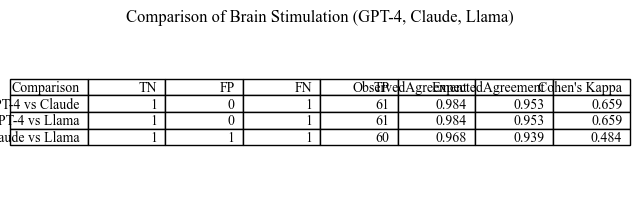

In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# 1) Configure matplotlib to use Times New Roman globally
plt.rcParams["font.family"] = "Times New Roman"

def compute_binary_agreement(df: pd.DataFrame, col_a: str, col_b: str) -> dict:
    """
    Computes confusion matrix, observed agreement, expected agreement,
    and Cohen's Kappa for two binary (0/1) columns.
    """
    a = df[col_a]
    b = df[col_b]

    # confusion_matrix(labels=[0,1]) => [[TN, FP], [FN, TP]]
    cm = confusion_matrix(a, b, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp

    # Observed agreement
    p_o = (tn + tp) / total if total else 0

    # Expected agreement
    row1_sum = tp + fn  # total '1' in col A
    row2_sum = fp + tn  # total '0' in col A
    col1_sum = tp + fp  # total '1' in col B
    col2_sum = fn + tn  # total '0' in col B
    if total == 0:
        p_e = 0
    else:
        p_e = (row1_sum * col1_sum + row2_sum * col2_sum) / (total**2)

    # Sklearn kappa
    kappa_sklearn = cohen_kappa_score(a, b)

    return {
        "ConfusionMatrix (tn, fp, fn, tp)": (tn, fp, fn, tp),
        "ObservedAgreement": p_o,
        "ExpectedAgreement": p_e,
        "CohensKappa": kappa_sklearn
    }
def df_to_png(df: pd.DataFrame, filename: str = "comparison_table.png", dpi=150, title=None):
    """
    Renders a DataFrame as a table in Matplotlib and saves as a PNG.
    Uses Times New Roman font. Minimizes extra whitespace by using
    constrained_layout and careful scaling.
    """
    # Smaller figure size; constrained_layout tries to handle spacing automatically
    fig, ax = plt.subplots(figsize=(8, 2), constrained_layout=True)  
    ax.axis("off")  # Hide the x/y axes
    
    if title:
        # Slightly reduce pad
        plt.title(title, fontsize=12, pad=5)  

    # Convert df to a list of lists (cell text) + list of column names
    table_data = [df.columns.tolist()] + df.values.tolist()
    # Create the table in the center
    tab = ax.table(cellText=table_data, loc="center")

    # Set a uniform font size
    tab.set_fontsize(11)

    # Remove or reduce table.scale if you want even tighter spacing:
    # tab.scale(1.0, 1.0)  # 1.0,1.0 means no scaling beyond default

    # Optionally, if you need columns 1..4 narrower:
    for (row, col), cell in tab.get_celld().items():
        if col in [1, 2, 3, 4]:
            cell.set_width(0.3)
        else:
            cell.set_width(1.0)
        # Center-align text
        cell.get_text().set_horizontalalignment("center")
        cell.get_text().set_verticalalignment("center")

    # We do NOT call plt.tight_layout() since constrained_layout=True is used.
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    print(f"Table saved to {filename}")

########################################
# 2) Load your DataFrame
########################################
output_dir = "03_data_ai"
os.makedirs(output_dir, exist_ok=True)

df_stats = pd.read_parquet(f"{output_dir}/part_3_covariates_final.parquet")
print("DataFrame loaded. Shape:", df_stats.shape)

########################################
# 3) Convert 'Yes'/'No' to 1/0
########################################
brain_stim_cols = [
    "brain_stimulation_used_gpt_4",
    "brain_stimulation_used_anthropic_claude_3.5_sonnet",
    "brain_stimulation_used_meta_llama_llama_3_70b_instruct"
]

for col in brain_stim_cols:
    df_stats[col] = df_stats[col].map({"Yes": 1, "No": 0})

df_stats.dropna(subset=brain_stim_cols, inplace=True)

for col in brain_stim_cols:
    df_stats[col] = df_stats[col].astype(int)

print("After converting Yes/No -> 1/0, dataframe shape:", df_stats.shape)
print(df_stats[brain_stim_cols].head(5))

########################################
# 4) Compare each pair
########################################
pairs_to_compare = [
    ("brain_stimulation_used_gpt_4",
     "brain_stimulation_used_anthropic_claude_3.5_sonnet",
     "GPT-4 vs Claude"),

    ("brain_stimulation_used_gpt_4",
     "brain_stimulation_used_meta_llama_llama_3_70b_instruct",
     "GPT-4 vs Llama"),

    ("brain_stimulation_used_anthropic_claude_3.5_sonnet",
     "brain_stimulation_used_meta_llama_llama_3_70b_instruct",
     "Claude vs Llama")
]

results_list = []

for col_a, col_b, label in pairs_to_compare:
    res = compute_binary_agreement(df_stats, col_a, col_b)
    tn, fp, fn, tp = res["ConfusionMatrix (tn, fp, fn, tp)"]
    row_dict = {
        "Comparison": label,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp,
        "ObservedAgreement": f"{res['ObservedAgreement']:.3f}",
        "ExpectedAgreement": f"{res['ExpectedAgreement']:.3f}",
        "Cohen's Kappa": f"{res['CohensKappa']:.3f}",
    }
    results_list.append(row_dict)

df_compare = pd.DataFrame(results_list)

########################################
# 5) Print & Save Table
########################################
print("\nPairwise Comparison of Brain Stimulation Columns:\n")
print(df_compare.to_string(index=False))

df_to_png(
    df_compare,
    filename="brain_stimulation_all_pairs.png",
    dpi=150,
    title="Comparison of Brain Stimulation (GPT-4, Claude, Llama)"
)

DataFrame loaded. Shape: (64, 68)
After converting Yes/No -> 1/0, dataframe shape: (63, 68)
   brain_stimulation_used_gpt_4  \
0                             1   
1                             1   
2                             1   
3                             1   
4                             1   

   brain_stimulation_used_anthropic_claude_3.5_sonnet  \
0                                                  1    
1                                                  1    
2                                                  1    
3                                                  1    
4                                                  1    

   brain_stimulation_used_meta_llama_llama_3_70b_instruct  
0                                                  1       
1                                                  1       
2                                                  1       
3                                                  1       
4                                                  1  

/var/folders/yt/5983d8ds4bzdkdnzv7nz9qk40000gn/T/ipykernel_5258/2276875895.py:81: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig(filename, dpi=dpi, bbox_inches="tight")
